# Explainable Artificial Intelligence (XAI) Practice

-    Feature Importances
-    Partial Dependence Plots
-    Model Prediction Explanations with Local Interpretation
-    Building Interpretable Models with Surrogate Tree-based Models
-    Model Prediction Explanation with SHAP values
-    Dependence & Interaction Plots with SHAP

### Loading Necessary Dependencies

In [1]:
import pandas as pd
import numpy as np
from utils.model_evaluation_utils import *
import matplotlib.pyplot as plt
from collections import Counter
import shap
import eli5

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

d:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Load and View the Census Income Dataset

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])

print(data.shape, labels.shape)
data.head()

(32561, 12) (32561,)


Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [3]:
Counter(labels)

Counter({0: 24720, 1: 7841})

### Basic Feature Engineering

In [4]:
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

### Building Train and Test Datasets

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
X_train.head(3)

(22792, 12) (9769, 12)


Age  Workclass  Education-Num  Marital Status  Occupation  \
19749  34.0          6            9.0               2           5   
1216   48.0          6           10.0               2           3   
27962  23.0          7           10.0               2          10   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
19749             5     4    0           0.0        2179.0            12.0   
1216              0     0    1        7688.0           0.0            40.0   
27962             0     4    1           0.0           0.0            30.0   

       Country  
19749       39  
1216        39  
27962       39

In [6]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


Age          Workclass  Education-Num       Marital Status  \
19749  34.0   Self-emp-not-inc            9.0   Married-civ-spouse   
1216   48.0   Self-emp-not-inc           10.0   Married-civ-spouse   
27962  23.0          State-gov           10.0   Married-civ-spouse   

             Occupation Relationship                 Race      Sex  \
19749   Farming-fishing         Wife                White   Female   
1216       Craft-repair      Husband   Amer-Indian-Eskimo     Male   
27962    Prof-specialty      Husband                White     Male   

       Capital Gain  Capital Loss  Hours per week         Country  
19749           0.0        2179.0            12.0   United-States  
1216         7688.0           0.0            40.0   United-States  
27962           0.0           0.0            30.0   United-States

### Training the classification model

In [7]:
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

Wall time: 33.1 s


### Making predictions on the test data

In [8]:
predictions = xgc.predict(X_test)
predictions[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])

### Model Performance Evaluation

In [9]:
class_labels = list(set(labels))
display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.90      0.94      0.92      7455
          1       0.76      0.67      0.71      2314

avg / total       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6972   483
        1        775  1539


### Classic feature importances from XGBoost

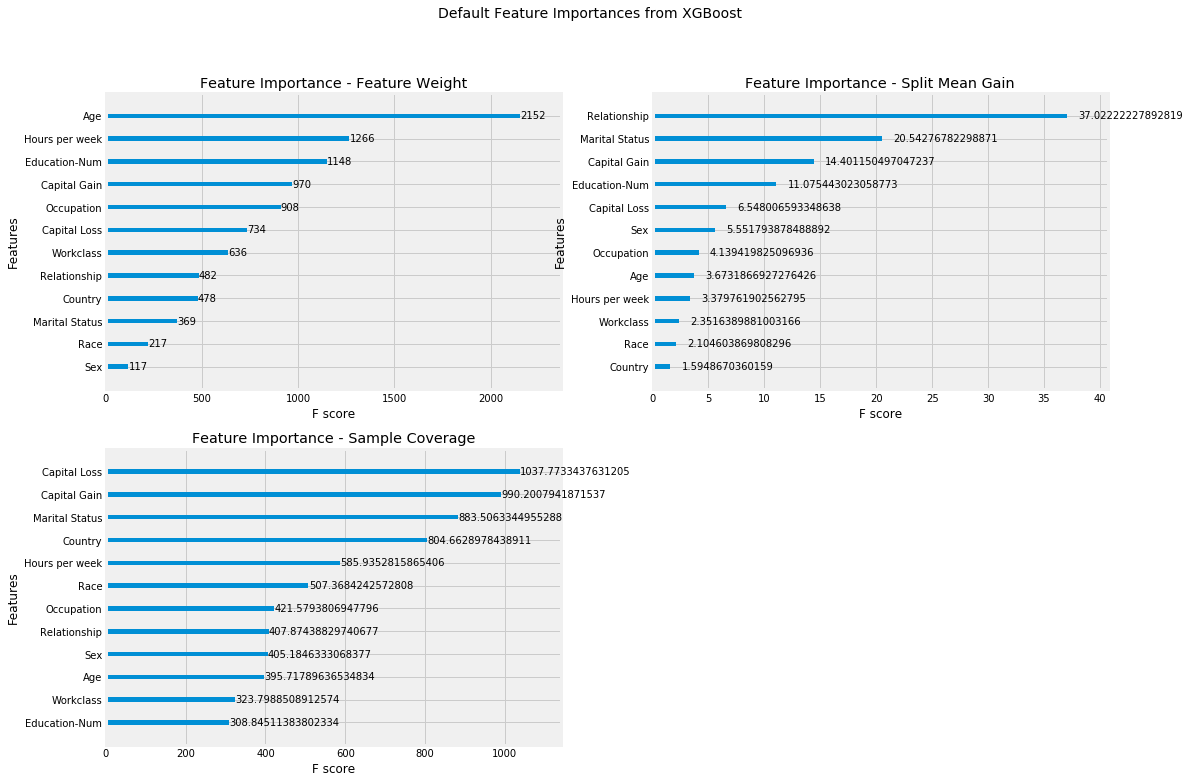

In [10]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

### Feature Importances with ELI5
 By information gain (default)

In [11]:
eli5.show_weights(xgc.get_booster())

Predicting when a person’s income <= $50K

In [12]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns),
show_feature_values=True)

Actual Label: 0
Predicted Label: 0


Predicting when a person’s income > $50K

In [13]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
eli5.show_prediction(xgc.get_booster(), X_test.iloc[doc_num], 
                     feature_names=list(data.columns), 
show_feature_values=True)

Actual Label: 1
Predicted Label: 1


### Model Interpretation with Skater

In [14]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(training_data=X_test, training_labels=y_test, 
                             feature_names=list(data.columns))
im_model = InMemoryModel(xgc.predict_proba, examples=X_train, 
target_names=['$50K or less', 'More than $50K'])

##### Feature Importances with Skater
- measuring the entropy in the change of predictions, given a perturbation of a given feature
- we’ll see predictions change as a function of perturbing a feature

2019-04-19 19:33:29,516 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 10 seconds

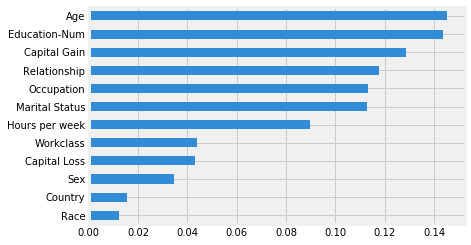

In [15]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, 
n_samples=23000)

##### Partial Dependence

PDP of ‘Age’ affecting model prediction

2019-04-19 19:34:18,556 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 21 seconds

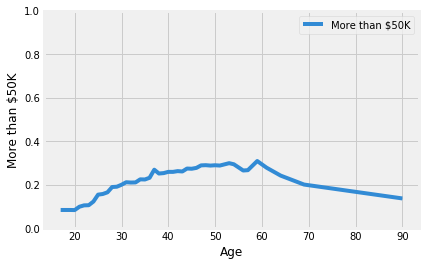

In [16]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

PDP of ‘Education Num’ affecting model prediction

2019-04-19 19:37:11,214 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 13 seconds

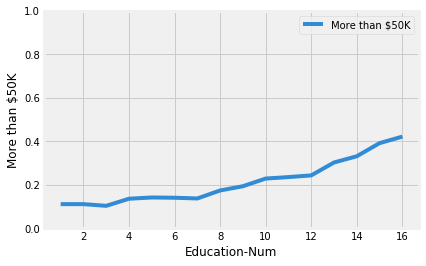

In [18]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

PDP of ‘Capital Gain’ affecting model prediction

2019-04-19 19:38:25,332 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 6 seconds

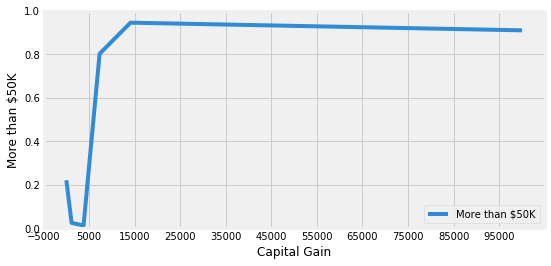

In [19]:
r = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (8, 4), n_samples=23000)
yl = r[0][1].set_ylim(0, 1) 
s, e = r[0][1].get_xlim()
xl = r[0][1].set_xticks(np.arange(s, e, 10000))

PDP of ‘Relationship’ affecting model prediction

In [22]:
pd.concat([data_disp[['Relationship']], data[['Relationship']]], 
axis=1).drop_duplicates()

Relationship  Relationship
0     Not-in-family             1
1           Husband             0
4              Wife             5
12        Own-child             3
17        Unmarried             4
74   Other-relative             2

2019-04-19 20:11:09,496 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[6/6] grid cells ████████████████████ Time elapsed: 6 seconds

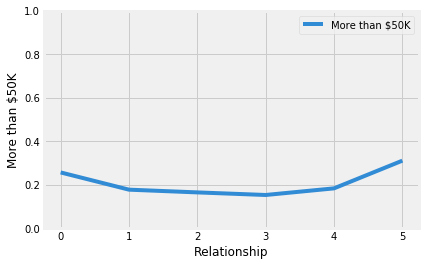

In [23]:
r = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], im_model, grid_resolution=50, 
                                                           grid_range=(0,1), n_samples=23000, 
                                                           with_variance=True, figsize = (6, 4))
yl = r[0][1].set_ylim(0, 1) 

##### Two-way PDP
- showing interactions between features ‘Age’ and ‘Education-Num’ and their effect on making more than $50K

2019-04-19 20:12:31,929 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1136/1136] grid cells ████████████████████ Time elapsed: 1036 seconds

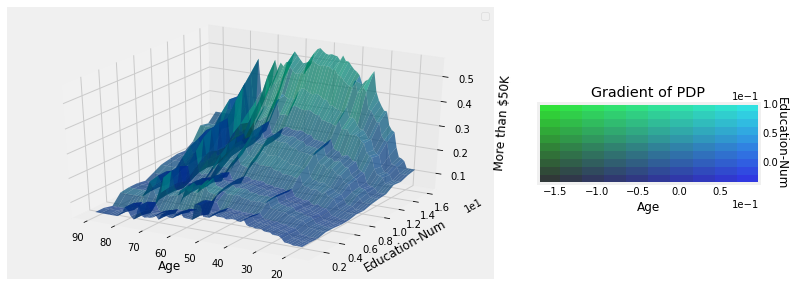

In [24]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
grid_resolution=100)

##### Two-way PDP
- showing interactions between features ‘Education-Num’ and ‘Capital Gain’ and their effect on making more than $50K

2019-04-19 20:34:37,946 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[160/160] grid cells ████████████████████ Time elapsed: 145 seconds

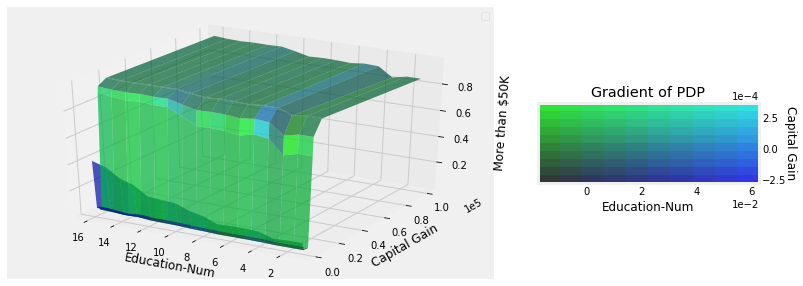

In [25]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Education-Num', 'Capital Gain')], 
                                                                    im_model, grid_range=(0,1), 
                                                                    n_samples=23000,
                                                                    figsize=(12, 5),
                                                                    grid_resolution=100)

### Local Interpretations with Skater

In [26]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                           objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [27]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
class_names=['$50K or less', 'More than $50K'])

Predicting when a person’s income <= $50K

In [28]:
doc_num = 0
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 0
Predicted Label: 0


Predicting when a person’s income > $50K

In [29]:
doc_num = 2
print('Actual Label:', y_test[doc_num])
print('Predicted Label:', predictions[doc_num])
exp.explain_instance(X_test.iloc[doc_num].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: 1
Predicted Label: 1


### interpretable models with Tree Surrogates using Skater  
- TREPAN algorithm
- Reports the fidelity value when compared to the base estimator (closer to 0 is better)

In [30]:
surrogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)

In [31]:
surrogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2019-04-19 20:43:39,421 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2019-04-19 20:43:39,427 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2019-04-19 20:43:43,147 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2019-04-19 20:43:43,180 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.889; oracle score 0.898


0.009

In [35]:
pd.DataFrame([('X'+str(idx), feature) 
for (idx, feature) in enumerate(data.columns)]).T

0          1              2               3           4             5   \
0   X0         X1             X2              X3          X4            X5   
1  Age  Workclass  Education-Num  Marital Status  Occupation  Relationship   

     6    7             8             9               10       11  
0    X6   X7            X8            X9             X10      X11  
1  Race  Sex  Capital Gain  Capital Loss  Hours per week  Country

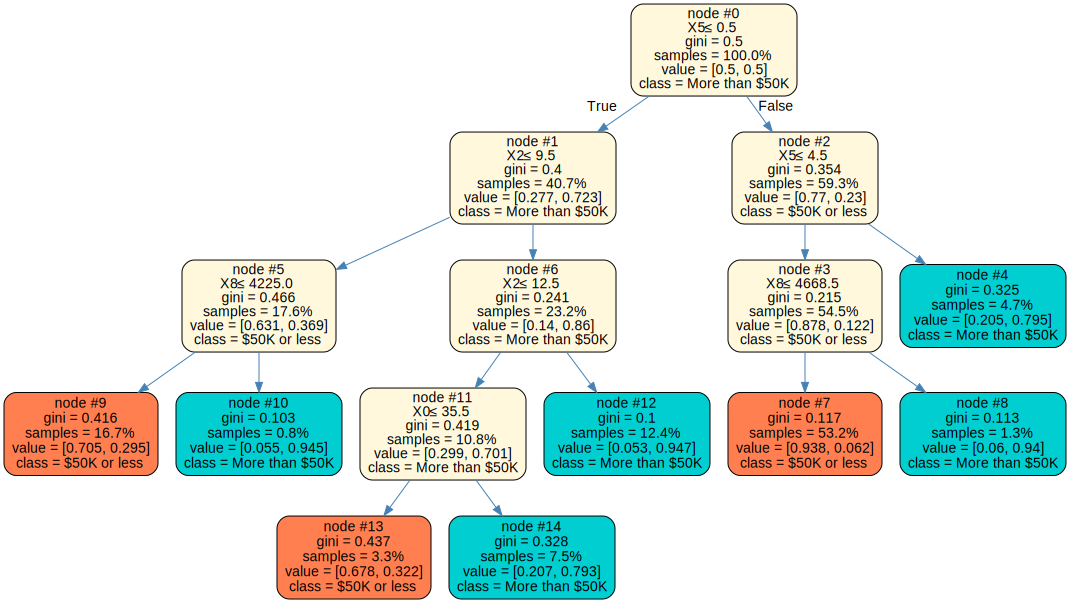

In [36]:
from skater.util.dataops import show_in_notebook
from graphviz import Source
from IPython.display import SVG

graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)

##### Interesting rules from the surrogate tree

- If Relationship < 0.5 (means 0) and Education-num <= 9.5 and Capital Gain <= 4225 → 70% chance of person making <= \$50K  
- If Relationship < 0.5 (means 0) and Education-num <= 9.5 and Capital Gain >= 4225 → 94.5% chance of person making > \$50K  
- If Relationship < 0.5 (means 0) and Education-num >= 9.5 and Education-num is also >= 12.5 → 94.7% chance of person making > \$50K  

### Surrogate Model Performance Evaluation

In [37]:
surrogate_predictions = surrogate_explainer.predict(X_test)
class_labels = list(set(labels))
display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=surrogate_predictions, 
classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8273
Precision: 0.8333
Recall: 0.8273
F1 Score: 0.8299

Model Classification report:
------------------------------
             precision    recall  f1-score   support

          0       0.90      0.87      0.89      7455
          1       0.62      0.68      0.65      2314

avg / total       0.83      0.83      0.83      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   0     1
Actual: 0       6504   951
        1        736  1578


## Model Interpretation with SHAP

The Shapley value ϕᵢⱼ is the average marginal contribution of feature value xᵢⱼ by joining whatever features already "entered the room" before.  
$$\phi_{ij}= \sum_{All.orderings} val(\{features.before.j\}\cup x_{ij})-val(\{features.before.j\})$$

![title](model_explanation/me_tradeoff_files/shap_exp.png)

In [38]:
explainer = shap.TreeExplainer(xgc)
shap_values = explainer.shap_values(X_test)
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head()

Expected Value: -1.3625857


0         1         2         3         4         5         6   \
0 -1.209206 -0.003895 -0.073927 -1.078541 -0.645259 -0.517731 -0.002871   
1  0.354368 -0.262398 -0.483883  0.586233  0.307967  1.194750  0.017408   
2 -0.525650  0.030637  0.970991  0.360480  0.528695  0.603971 -0.103895   
3 -0.426095  0.076188  0.576406 -1.108961 -0.517884 -0.522604  0.028896   
4 -0.503867 -0.159754 -0.129339 -0.547773 -0.049194 -0.414065 -0.019701   

         7         8         9         10        11  
0 -0.421329 -0.144742 -0.036394 -0.568053 -0.004587  
1 -0.216272 -0.108322 -0.048158 -0.095782  0.017657  
2  0.050630 -0.176231 -0.087669  0.509656  0.024573  
3 -0.359870 -0.142805 -0.057430 -0.250736  0.023183  
4  0.128197 -3.685364 -0.031033  0.781617  0.001285

##### Predicting when a person’s income <= $50K

In [39]:
shap.force_plot(explainer.expected_value, 
                shap_values[0,:], X_test_disp.iloc[0,:])

##### Predicting when a person’s income > $50K

In [40]:
shap.force_plot(explainer.expected_value, 
                shap_values[2,:], X_test_disp.iloc[2,:])

##### Visualizing and explaining multiple predictions

In [41]:
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_disp.iloc[:1000,:])

##### Feature Importances with SHAP

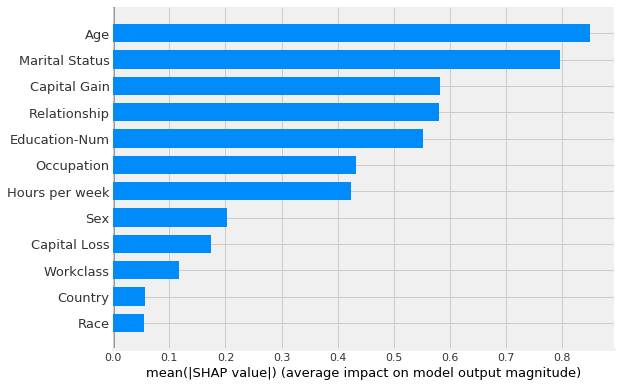

In [42]:
shap.summary_plot(shap_values, 
                  X_test, plot_type="bar")

##### SHAP Summary Plot

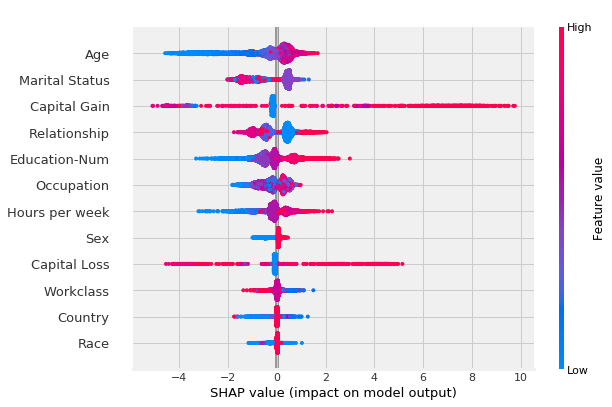

In [43]:
shap.summary_plot(shap_values, X_test)

#### SHAP Dependence Plots

PDP of ‘Age’ affecting model prediction

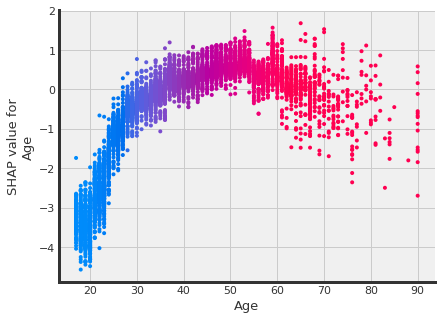

In [44]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

PDP of ‘Education-Num’ affecting model prediction

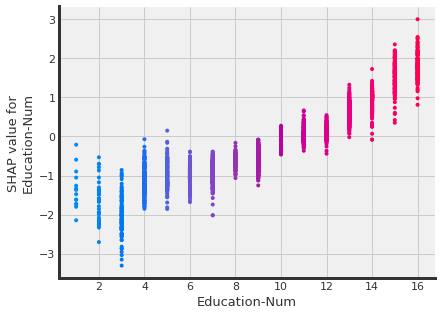

In [45]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

PDP of ‘Relationship’ affecting model prediction

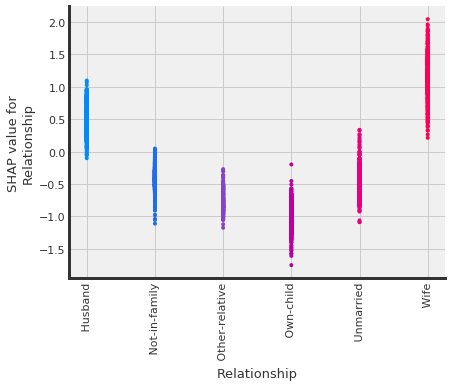

In [46]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

PDP of ‘Capital Gain’ affecting model prediction

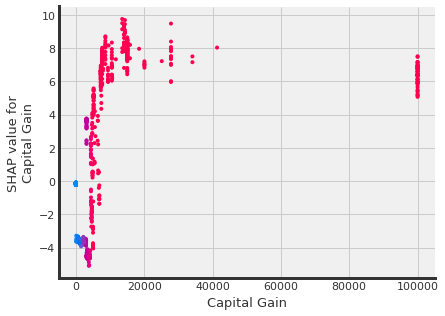

In [47]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

Two-way PDP showing interactions between features ‘Age’ and ‘Capital Gain’ and their effect on making more than $50K

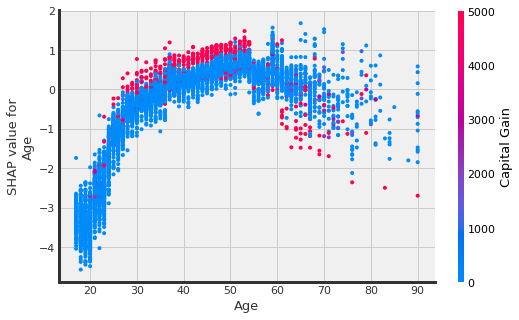

In [48]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

Two-way PDP showing interactions between features ‘Education-Num’ and ‘Relationship’ and their effect on making more than $50K

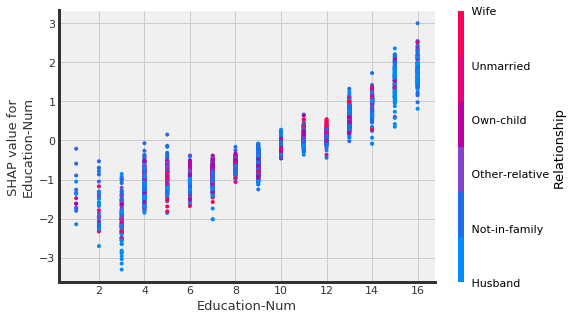

In [49]:
shap.dependence_plot(ind='Education-Num', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

Two-way PDP showing interactions between features ‘Marital Status’ and ‘Relationship’ and their effect on making more than $50K

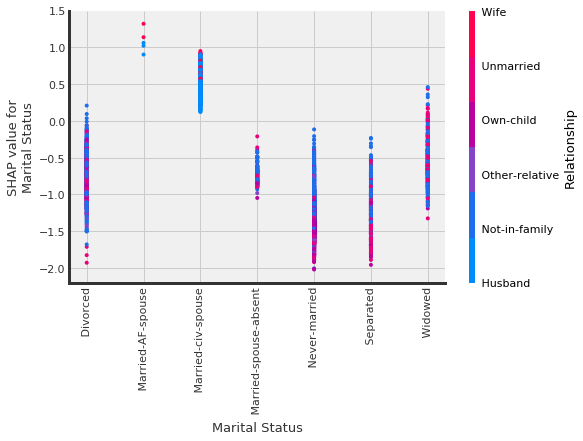

In [50]:
shap.dependence_plot(ind='Marital Status', interaction_index='Relationship', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

Two-way PDP showing interactions between features ‘Age’ and ‘Hours per week’ and their effect on making more than $50K

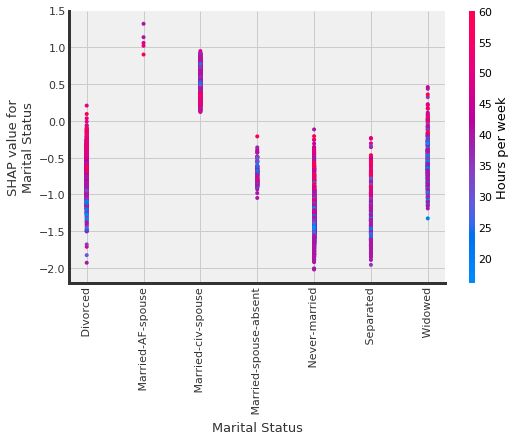

In [51]:
shap.dependence_plot(ind='Marital Status', interaction_index='Hours per week', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)